<DIV ALIGN=CENTER>

# Introduction to Hierarchical Modeling
## Professor Robert J. Brunner
  
</DIV>  
-----
-----

## Introduction

In this IPython Notebook, we build on the topics presented in the
Bayesian Modeling notebook to model hierarchical problems. A
hierarchical model not only models the entire data set, it also
simultaneously models subsets. For example, if sales data is encoded by
the day of the week, a hierarchical approach could model the entire
sales data while also modeling the sales for each day of the week. This
technique is sometimes called pooled data, since we model the individual
data subsets as well as the entire data pooled together.

We will again use the pymc3 library to compute the model parameters and
to sample from the likelihood.

-----




In [13]:
print(pm.__version__)

3.0


In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

-----

### Model

The underlying model we will use in this notebook is a simple linear
model as used previously. In this case, we now include a dictionary of
_model_ parameters to enable easy computation of data for plotting. We
also have separated the random component of the model from the linear
model itself to simplify  resulting analyses. Finally, we compute five
different binned samples of the model (each with different numbers of
sample points) and visualize the resulting model for the aggregated data.

-----

In [2]:
# Some common definitions
n_samples = 5000
n_burn = int(n_samples / 2)

# We define a simple function to fit.

np.random.seed(23)

# A non-linear equation
def theModel(x, params = None):

    # Default values
    beta = 0.5
    alpha = 0.25

    if params:
        alpha = params['Intercept']
        beta = params['Slope']

    return (alpha + beta * x)

# Add random noise to model
def randomizeModel(xmin=0, xmax = 1, num=20):
    
    sigma = 0.1
    
    x = np.linspace(xmin, xmax, num)   
    y = theModel(x) + sigma * np.random.randn(len(x))

    return(x, y)

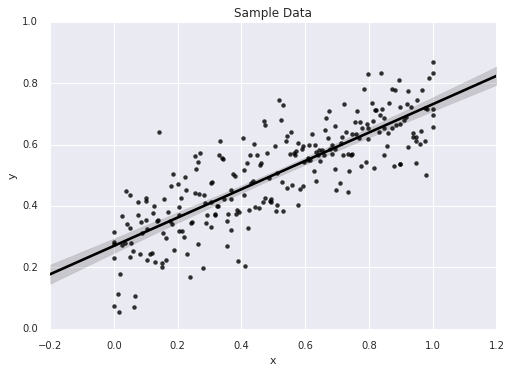

In [3]:
# Generate model data in n_bins

n_bins = 5
n_pts = [20, 40, 50, 60, 80]

# Obtain sample data and plot data and model fit

x = [] ; y = [] ; b = []

for bin in range(n_bins):
    x_i, y_i = randomizeModel(num = n_pts[bin])
    b_i = [bin] * n_pts[bin]
    
    x.extend(x_i)
    y.extend(y_i)
    b.extend(b_i)

# Make a dataframe to hold the data and associated bin (categorical)
df = pd.DataFrame({'x': x, 'y': y, 'b': b})

# Plot entire data.
ax = sns.regplot(data = df, x = 'x', y = 'y', \
                 fit_reg=True, color='black', label="Data")
ax.set(title='Sample Data')
sns.despine(offset=5, trim=True)

-----
### Independent Bayesian Modeling

To begin, we will perform a standard Bayesian modeling of each separate 
data set, which is known as unpooled modeling. This approach is also not
hierarchical as we do not fit each data set while also fitting the
entire, pooled data set. While conceptually straightforward, an unpooled
approach is unable to capitalize on the additional information provided
by the entire data set when fitting each data subset. In this case,
however, we perform the unpooled modeling to provide a comparison
baseline for the pooled models we will compute next. 

In the following code cell, we perform the fitting for each data set by
solely using the data in each respective bin. We make one change from
the previous notebook example, in the we now model the prior for the
`intercept` as a normal distribution.

-----

In [4]:
# This example follow the example in the pymc3 documentation
# http://pymc-devs.github.io/pymc3/GLM-hierarchical/
import pymc3 as pm

indiv_traces = {}

for bin in range(n_bins):

    # Select subset of data belonging to county
    b_df = df.ix[df.b == bin]
    b_x = b_df.x
    b_y = b_df.y
    
    print('\n\nComputing Posterior for bin {0}'.format(bin))

    with pm.Model() as bin_model:
    
        # First, define stochastic model variables
        intercept = pm.Normal('Intercept', mu = 0.25, sd = 1.0)
        slope = pm.Normal('Slope', mu = 1.0, sd = 1.0)
        
        # Now define stochastic variable for observation errors.    
        sigma = pm.Normal('sigma', mu = 1., sd = 2.0)

        # Expected values using original indepedent variables
        # Deterministic Variable
        b_y_exp =  intercept + slope * b_x

        # Sample values (likelihood)
        likelihood = pm.Normal('yn', mu=b_y_exp, sd=sigma, observed=b_y)
        
        # Compute starting point, define sampler, 
        # and generate traces from the likelihood
        start = pm.find_MAP()
        step = pm.NUTS(scaling=start)
        trace = pm.sample(n_samples, step=step, start=start)
    
    # keep trace for later analysis
    indiv_traces[bin] = trace



Computing Posterior for bin 0
 [-----------------100%-----------------] 5000 of 5000 complete in 4.3 sec

Computing Posterior for bin 1
 [-----------------100%-----------------] 5000 of 5000 complete in 3.5 sec

Computing Posterior for bin 2
 [-----------------100%-----------------] 5000 of 5000 complete in 3.0 sec

Computing Posterior for bin 3
 [-----------------100%-----------------] 5000 of 5000 complete in 3.6 sec

Computing Posterior for bin 4
 [-----------------100%-----------------] 5000 of 5000 complete in 3.5 sec

-----

## Hierarchical Modeling

Next, we apply Bayesian Hierarchical Modeling, where we fit the entire
data set, while also modeling each data subset. To do this, we first
define the parameters for the individual data, which we now do by using
stochastic variables: `mui_i` and `sigmai_i` for the end points of the
normal distribution for the `intercept` value, and `mus_i` and `sigmas_i`
for the normal distribution for the `slope` value. In addition, we
specify that there should be `n_bins` different `slope` and `intercept`
prior values generated, one for each independent data set.

Otherwise, the modeling proceeds as before, except our expected and
observed values for the dependent variable (`y`) are binned quantities,
where the bin value is a categorical column in the DataFrame.

-----

In [5]:
b_idx = df['b'].values

with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mui_i = pm.Normal('mui_i', mu=0.0, sd=0.5**2)
    sigmai_i = pm.Uniform('sigmai_i', lower=0.0, upper=1.0)
  
    mus_i = pm.Normal('mus_i', mu=0.0, sd=0.5**2)
    sigmas_i = pm.Uniform('sigmas_i', lower=0.0, upper=1.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).

    intercept = pm.Normal('Intercept', mu = mui_i, sd = sigmai_i, shape=n_bins)
    slope = pm.Normal('Slope', mu = mus_i, sd = sigmas_i, shape=n_bins)

    # Now define stochastic variable for observation errors.    
    sigma = pm.Normal('Sigma', mu = 1., sd = 2.0)

    # Expected values using original indepedent variables
    # Deterministic Variable
    y_exp =  intercept[b_idx] + slope[b_idx] * df.x

    # Sample values (likelihood)
    likelihood = pm.Normal('yn', mu=y_exp, sd=sigma, observed=df.y)

Applied interval-transform to sigmai_i and added transformed sigmai_i_interval_ to model.
Applied interval-transform to sigmas_i and added transformed sigmas_i_interval_ to model.


In [6]:
# Compute the hierarhical model likelihood and generate sample points.
with hierarchical_model:
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    hierarchical_trace = pm.sample(n_samples, step, start=start, progressbar=True)

 [-----------------100%-----------------] 5000 of 5000 complete in 39.5 sec

-----

### Analyze Hierarchical Results

We can analyze the model parameters as before, however, the trace values
are now tagged with the bin value to which they belong. As a result,
when we analyze the traces, we obtain bin-dependent trace statistics.
As expected, the precision of a statistical summary of the trace becomes
better with increasing number of data points (i.e., higher bin number in
our example). 

-----

In [7]:
pm.summary(hierarchical_trace[-n_burn:], \
           varnames=['Slope', 'Intercept', 'Sigma', 'mui_i', 'sigmai_i', 'mus_i', 'sigmas_i'])


Slope:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.450            0.032            0.001            [0.387, 0.517]
  0.461            0.028            0.001            [0.406, 0.517]
  0.448            0.028            0.001            [0.395, 0.506]
  0.462            0.026            0.001            [0.411, 0.513]
  0.465            0.025            0.001            [0.415, 0.513]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.380          0.431          0.451          0.470          0.511
  0.407          0.442          0.461          0.479          0.518
  0.388          0.432          0.449          0.466          0.502
  0.413          0.444          0.462          0.479          0.516
  0.416          0.448          0.463          0.482          0.515


Intercep

-----

### Visualize Hierarchical Results

Likewise, we can visualize the traces as before, but we now see the
bin-dependent traces for the model parameters. If one really wishes to
explore the traces or the distribution of the trace values, it will
likely be necessary to visualize them directly as done in the Bayesian
Modeling Notebook.

-----

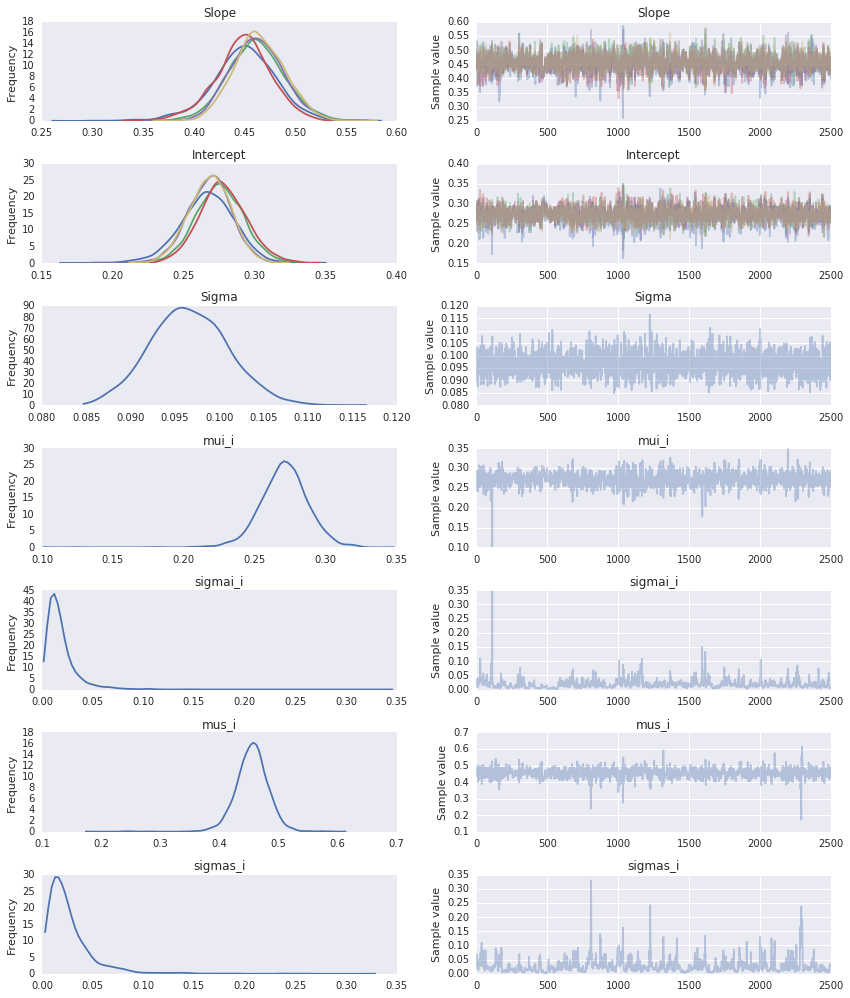

In [8]:
sns.set_style('darkgrid')
pm.traceplot(hierarchical_trace[-n_burn:], \
             varnames=['Slope', 'Intercept', 'Sigma', 'mui_i', 'sigmai_i', 'mus_i', 'sigmas_i'])
plt.show()

-----

## Method Comparison

We can compare the model predictions for the unpooled and pooled model
fits by computing the statistical characterizations of each model from
their respective traces and overplotting the data, true model, and the
individual and hierarchical model fits. We first define a helper
function to plot model fits given the data and traces, before plotting
the results for four of the five bins in our data set.

-----

In [9]:
# Helper function for plotting data, and model fit regressions
def makePlot(df, i_traces, h_traces, c_bin):
    # Set up plot
    sns.set(font_scale=1.0)

    # Grab the bin data
    c_trace = i_traces[c_bin]

    # plot the data for current bin
    ax = sns.regplot(data = df.ix[df.b == c_bin], x = 'x', y = 'y', \
                     fit_reg=False, color='black', label="Data")

    # Compute and plot the true relationship
    x_sample = np.linspace(-0.1, 1.1, 100)
    y_sample = theModel(x_sample)
    plt.plot(x_sample, y_sample, color='r', lw=3, alpha = 0.75, \
             label='True Regression')

    # Define the mean, hiearchical posterior parameters for current bin
    params = {}
    params['Intercept'] = np.mean(h_traces['Intercept'][-n_burn:, c_bin]) 
    params['Slope'] = np.mean(h_traces['Slope'][-n_burn:, c_bin])

    # Compute and plot the mean, hiearchical posterior prediction
    y_est = theModel(x_sample, params)
    plt.plot(x_sample, y_est, color='b', lw=3, alpha = 0.75, \
             label='Hiearchical Posterior Regression')

    # Define the mean, unpooled posterior parameters for the current bin
    params = {}
    params['Intercept'] = np.mean(c_trace['Intercept'][-n_burn:]) 
    params['Slope'] = np.mean(c_trace['Slope'][-n_burn:])

    # Compute and plot the mean, unpooled posterior prediction
    y_est = theModel(x_sample, params)
    plt.plot(x_sample, y_est, color='g', lw=3, alpha = 0.75, \
             label='Unpooled Posterior Regression')
    
    # Decorate plot
    plt.title('Bin {0} Posterior Predictions'.format(c_bin))
    lgnd = plt.legend(loc='upper left')

    for lg in lgnd.legendHandles:
        lg.set_linewidth(2.0)
        
    plt.xlabel('x')
    plt.ylabel('y')

    sns.despine(offset=5, trim=True)
    sns.set(font_scale=1)

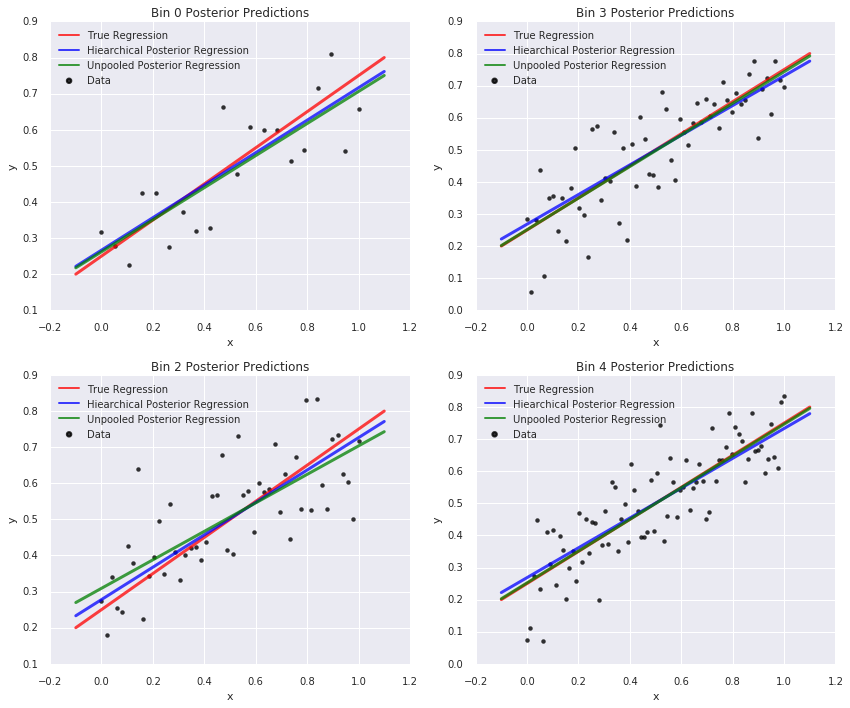

In [10]:
# Plot four bins
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
makePlot(df, indiv_traces, hierarchical_trace, 0)

plt.subplot(2, 2, 3)
makePlot(df, indiv_traces, hierarchical_trace, 2)

plt.subplot(2, 2, 2)
makePlot(df, indiv_traces, hierarchical_trace, 3)

plt.subplot(2, 2, 4)
makePlot(df, indiv_traces, hierarchical_trace, 4)

plt.tight_layout()

-----

### Hierarchical Modeling Effects

We can also examine how the effect of performing a hierarchical model
affected the modeling of the individual data sets. To do this, we
compute the parameter values for each binned data set, and plotting the
change in the location of each posterior sample point. In this manner,
we can see the effect of pooling the data, which tends to pull the
individual fits toward the global fit (indicated in the plot by the black
plus sign). Also, notice how far the parameter values for the different
bins move, which is related to the number of points in each bin.

-----

In [11]:
# Make Shrinkage Plot

# Compute mean quantities for plot
hier_i = hierarchical_trace['Intercept'][-n_burn:].mean(axis=0)
hier_s = hierarchical_trace['Slope'][-n_burn:].mean(axis=0)
indv_i = [indiv_traces[b]['Intercept'][-n_burn:].mean() for b in range(n_bins)]
indv_s = [indiv_traces[b]['Slope'][-n_burn:].mean() for b in range(n_bins)]

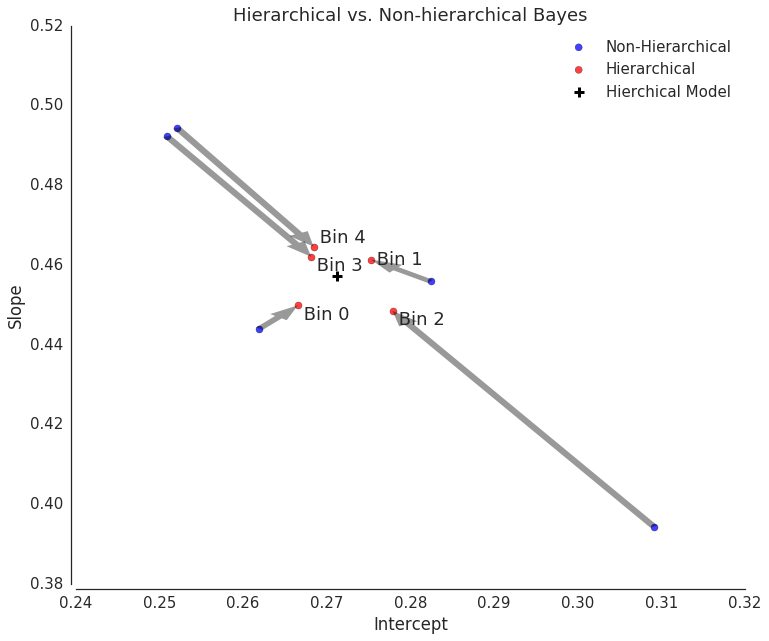

In [12]:
fig = plt.figure(figsize=(12, 10))
sns.set(font_scale=1.5)
sns.set_style('white')

# plot individual and hierarchical model sample parameter values.
plt.scatter(indv_i, indv_s, c='b', s=50, alpha=0.75, label = 'Non-Hierarchical')
plt.scatter(hier_i, hier_s, c='r', s=50, alpha=0.75, label = 'Hierarchical')

# Plot arrows linking individual to hierarchical
vlocs = ['top', 'center', 'top', 'top', 'bottom']
for i in range(len(indv_s)):  
    plt.arrow(indv_i[i], indv_s[i], hier_i[i] - indv_i[i], hier_s[i] - indv_s[i], \
              fc="k", ec="k", length_includes_head=True, \
              alpha=0.4, head_width=.0025, lw =0.001)
    plt.text(hier_i[i], hier_s[i], ' Bin {0}'.format(i), \
             size = 18, ha='left', va=vlocs[i])


# Plot Full hierarchical model sample parameters
xh = hierarchical_trace['Intercept'][-n_burn:].mean()
yh = hierarchical_trace['Slope'][-n_burn:].mean()
plt.scatter(xh, yh, c='k', s=100, marker='+', alpha = 1, lw=3, label='Hierchical Model')

# Decorate Plot
plt.title('Hierarchical vs. Non-hierarchical Bayes')

lgnd = plt.legend(loc=0)
plt.xlabel('Intercept')
plt.ylabel('Slope')

sns.despine(offset=5, trim=True)
sns.set(font_scale=1)
plt.show()

-----

### Student Activity

In the preceding cells, we introduced Bayesian Hierarchical modeling.
Now that you have run the Notebook, go back and make the following
changes to see how the results change.

1. Change the model parameters, rerun the Notebook and see how the
different (unpooled versus pooled) modeling approaches perform.
2. Change the number of points in each bin, rerun the Notebook and see
how the different (unpooled versus pooled) modeling approaches perform.
3. Change the model for the prior distributions, e.g., try a uniform
distribution for the intercept. How do the different (unpooled versus
pooled) modeling approaches perform?

-----